# Preliminary Comparison of Biologically Informed Neural Networks (BINNs) and a Traditional Hyper Geometric Test (GOfuncR) for Pathway Analysis in Human Cancer Transcriptomic Data
## Introduction and Motivation

In order to examine the capability of Biologically Informed Neural Networks (BINNs) for their use in pathway analysis, we compare the R library *__GOFuncR__* (a traditional hypergeometric test) (Grote S (2025). GOfuncR: Gene ontology enrichment using FUNC. doi:10.18129/B9.bioc.GOfuncR, R package version 1.28.0, https://bioconductor.org/packages/GOfuncR.) to the Python library *__binn__* (Hartman, E., Scott, A.M., Karlsson, C. et al. Interpreting biologically informed neural networks for enhanced proteomic biomarker discovery and pathway analysis. Nat Commun 14, 5359 (2023). https://doi.org/10.1038/s41467-023-41146-4)

We have forked the *__binn__* repository to extend the design to use an omic specific L1 lasso penalty to integrate multiple omic types as input, as well as implement new visualizations. For this preliminary test, we use the single omic BINN implementation by Hartman et al. (2023) with a few custom graphs.

Our input data is human transcript expression in E-MTAB-2770-query-results.fpkms.tsv from Barretina J, Caponigro G, Stransky N, Venkatesan K, Margolin AA et al. (2012) The Cancer Cell Line Encyclopedia enables predictive modelling of anticancer drug sensitivity. and
Ghandi M, Huang FW, Jané-Valbuena J, Kryukov GV, Lo CC et al. (2019) Next-generation characterization of the Cancer Cell Line Encyclopedia.

We used the BINN as a binary classifier to compare with GOfuncR. As such, we selected the samples of the 2 largest cancer types in the dataset, lung adenocarcinoma (40 samples) and melanoma (68 samples). The underlying ontology used is changed from the default Reactome to use the Gene Ontology. We define the relationships between genes and GO terms  as well as GO term:GO term relationships in human_genes_go_terms_extended.txt and go_parent_child.txt respectively.

Training the BINN with a 0.2 dropout rate and 20% test train validation split produced the following.

![alt text](image-3.png)

Each node, representing an ontological term, has an importance value produced from the DEEPShap algorithm for it's relative importance in classifying each sample condition (i.e. cancer type) in the analysis. Our hope is to use BINNs for more complex designs than classifying 2 levels. But in order to do that, we first must understand how the DEEPShap importances relate to the level of classification.

For 100 epochs, we get loss functions which appear stable but show overfitting, so we reduce the amount of epochs to 35.

![alt text](image-2.png)

Reducing to 35 shows the following

![alt text](image-1.png)

Running *__binn__* also produces a csv (cancer_single_explanations.csv) containing the DEEPShap importances calculated for each node/GO Term, which we will use to compare to the results of GOfuncR. 

note: we are running a forked version of *__binn__* on our institution's local cluster, but the code to a BINN are as follows:

In [ ]:
import torch
from binn import BINN, BINNDataLoader, BINNTrainer, BINNExplainer
import pandas as pd

# Load data
data_matrix = pd.read_csv("cancer_transcriptomics.tsv", sep="\t")
design_matrix = pd.read_csv("cancer_design.tsv", sep="\t")

# Initialize BINN
binn = BINN(data_matrix=data_matrix, n_layers=5, dropout=0.2)

# Initialize DataLoader
binn_dataloader = BINNDataLoader(binn)

# Create DataLoaders
dataloaders = binn_dataloader.create_dataloaders(
    data_matrix=data_matrix,
    design_matrix=design_matrix,
    feature_column="Gene ID",
    group_column="treatment",
    sample_column="sample",
    batch_size=32,
    validation_split=0.2,
)
# Train the model
trainer = BINNTrainer(binn)
trainer.fit(dataloaders=dataloaders, num_epochs=35)

# Explain the model
explainer = BINNExplainer(binn)
single_explanations = explainer.explain_single(dataloaders, split="val", normalization_method="subgraph")
single_explanations.to_csv('cancer_single_explanations.csv', index=False)

!which pipBelow is a wrapped R script used to run GOfuncR, as well as produce the input data for our BINN. To run R in the notebook, we use rpy2 and load the R_HOME path using os.

In [1]:

!which pip
!pip show rpy2
!python3 -m pip install ipykernel
!python3 -m ipykernel install --user --name rpy2_env --display-name "Python (rpy2-3.5.10)"

/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/python/3.11.5/bin/pip
Name: rpy2
Version: 3.5.10
Summary: Python interface to the R language (embedded R)
Home-page: 
Author: 
Author-email: Laurent Gautier <lgautier@gmail.com>
License: GPLv2+
Location: /home/mkralj/.local/lib/python3.11/site-packages
Requires: cffi, jinja2, pytz, tzlocal
Required-by: 
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
I

In [3]:
#!pip install "pandas==1.5.3" --force-reinstall
#!pip uninstall -y rpy2
#!pip install rpy2==3.5.10
import pandas
import rpy2


import os
os.environ['R_HOME'] = "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/r/4.4.0/lib64/R"
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Data Cleaning

First we extract the largest sample types from the cancer transcriptomic data (lung adenocarcinoma, melanoma) and make a design matrix based on this.

In [4]:
%%R
#install.packages(c("dplyr","tidyverse", "BiocManager"), repos = "https://cloud.r-project.org/")
#BiocManager::install(c"biomaRt","GOfuncR"))
.libPaths("~/projects/def-rleduc42/mkralj/R_packages")
library("dplyr")
library("tidyverse")


extract_after_comma <- function(string_vector) {
  result <- sub("^[^,]*,\\s*", "", string_vector)
  return(result)
}

transcriptomics <- read_tsv("E-MTAB-2770-query-results.fpkms.tsv")
cols_to_extract<- c("Gene ID", "lung adenocarcinoma", "melanoma")
isolated_names <- extract_after_comma(colnames(transcriptomics))
isolated_names <- isolated_names %in% cols_to_extract
transcriptomics <- transcriptomics[,isolated_names]

write_tsv(transcriptomics, "cancer_transcriptomics.tsv")

transcriptomics <- column_to_rownames(transcriptomics, "Gene ID")

sample_info <- data.frame(sample=colnames(transcriptomics))
sample_info$treatment <- ifelse(grepl("melanoma", sample_info$sample, ignore.case = TRUE), 1,0)
sample_info$treatment <- as.factor(sample_info$treatment)

write_tsv(sample_info, "cancer_design.tsv")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.2     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 55843 Columns: 1021
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr    (2): Gene ID, Gene Name
dbl (1019): 22Rv1, prostate carcinoma, 23132/87, gastric adenocarcinoma, 253...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

from rpy2.robjects.packages import importr

pandas2ri.activate()

r_transcriptomics = robjects.globalenv['transcriptomics']
r_sample_info = robjects.globalenv['sample_info']

transcriptomics_pd = pandas2ri.rpy2py(r_transcriptomics)
sample_info_pd = pandas2ri.rpy2py(r_sample_info)

print("Head of transcriptomics dataframe:")
display(transcriptomics_pd.head())
print("\nHead of sample_info dataframe:")
display(sample_info_pd.head())

Head of transcriptomics dataframe:


,"A101D, melanoma","A427, lung adenocarcinoma","A549, lung adenocarcinoma","ABC-1, lung adenocarcinoma","CJM, melanoma","COLO 792, melanoma","COLO 829, melanoma","COLO-679, melanoma","COLO-783, melanoma","COLO-800, melanoma",...,"SK-MEL-3, melanoma","SK-MEL-31, melanoma","UACC-257, melanoma","UACC-62, melanoma","WM-115, melanoma","WM-266-4, melanoma","WM-793, melanoma","WM-88, melanoma","WM1799, melanoma","WM983B, melanoma"
ENSG00000000003,4.0,8.0,15.0,15.0,5.0,9.0,5.0,5.0,10.0,3.0,...,8.0,7.0,11.0,11.0,4.0,8.0,3.0,5.0,4.0,4.0
ENSG00000000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000000419,89.0,72.0,51.0,82.0,75.0,31.0,41.0,60.0,62.0,56.0,...,120.0,49.0,48.0,53.0,35.0,47.0,59.0,107.0,56.0,105.0
ENSG00000000457,2.0,2.0,2.0,3.0,1.0,1.0,2.0,4.0,3.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0
ENSG00000000460,5.0,3.0,4.0,6.0,1.0,3.0,2.0,6.0,4.0,5.0,...,5.0,2.0,5.0,3.0,2.0,3.0,6.0,6.0,6.0,4.0



Head of sample_info dataframe:


,sample,treatment
1,"A101D, melanoma",2
2,"A427, lung adenocarcinoma",1
3,"A549, lung adenocarcinoma",1
4,"ABC-1, lung adenocarcinoma",1
5,"CJM, melanoma",2


### Differential Expression Analysis

To determine the differentially expressed transcripts, we run a simple t-test for each transcript and apply a Benjamani-Hochberg multiple test correction.

In [6]:
%%R

# function for running t-tests
run_t_tests <- function(expression_data, sample_info) {
  group_info <- sample_info$treatment
  names(group_info) <- sample_info$sample
  
  expression_data <- expression_data[, names(group_info)]
  
  results <- data.frame(
    transcript_id = rownames(expression_data),
    p_value = NA,
    t_statistic = NA,
    mean_group1 = NA,
    mean_group2 = NA,
    log2FC = NA,
    stringsAsFactors = FALSE
  )
  
  
  skipped_transcripts <- c()
  
  # loop over all rows in dataframe
  for (i in 1:nrow(expression_data)) {
    expr_values <- as.numeric(expression_data[i, ])
    transcript_id <- rownames(expression_data)[i]
    
    group_counts <- table(group_info)
    group_has_data <- tapply(expr_values, group_info, function(x) sum(!is.na(x)) > 1)
    
    if (all(group_has_data)) {
      # catch failed t-tests
      tryCatch({
        t_result <- t.test(expr_values ~ group_info)
        
        means <- tapply(expr_values, group_info, mean, na.rm = TRUE)
        
        results$p_value[i] <- t_result$p.value
        results$t_statistic[i] <- t_result$statistic
        results$mean_group1[i] <- means[1]
        results$mean_group2[i] <- means[2]
        results$log2FC[i] <- log2(means[2] / means[1])
      }, 
      error = function(e) {
        skipped_transcripts <<- c(skipped_transcripts, transcript_id)
      })
    } else {
      
      skipped_transcripts <<- c(skipped_transcripts, transcript_id)
    }
  }
  
  # exclude NA results from FDR correction
  non_na_indices <- which(!is.na(results$p_value))

  if (length(non_na_indices) > 0) {
    adj_p_values <- rep(NA, nrow(results))
    adj_p_values[non_na_indices] <- p.adjust(results$p_value[non_na_indices], method = "BH")
    results$adjusted_p_value <- adj_p_values
    
    results <- results[order(is.na(results$p_value), results$p_value), ]
  } else {

    results$adjusted_p_value <- NA
    
  }
  
  return(list(
    results = results,
    skipped_transcripts = skipped_transcripts
  ))
}

t_test_result_list <- run_t_tests(transcriptomics, sample_info)
t_test_results <- t_test_result_list$results
skipped_transcripts <- t_test_result_list$skipped_transcripts

In [7]:
t_test = robjects.globalenv['t_test_results']

t_test_pd = pandas2ri.rpy2py(t_test)

print("Head of t-test results dataframe:")
display(t_test_pd.head())

Head of t-test results dataframe:


,transcript_id,p_value,t_statistic,mean_group1,mean_group2,log2FC,adjusted_p_value
14765,ENSG00000180263,1.536203e-17,11.412728,6.716176,0.677500,-3.309347,5.594545e-13
1985,ENSG00000092871,4.146132e-17,10.232836,3.475000,1.015000,-1.775533,6.113063e-13
7028,ENSG00000135314,5.035748e-17,10.363896,2.471212,0.517143,-2.256584,6.113063e-13
469,ENSG00000028203,1.438630e-16,9.949932,12.382353,5.525000,-1.164239,1.187560e-12
3483,ENSG00000108091,1.630458e-16,9.946108,12.367647,5.525000,-1.162525,1.187560e-12


### Hypergeometric Test

Once we have the list of differentially expressed transcripts, we run the hypergeometric test using go_enrich to get a list of GO terms with an associated p-value.

In [9]:
%%R

library(biomaRt)
library(GOfuncR)

# convert supplied gene ID to ensembl ID

transcript_to_gene <- function(transcript_ids) {
  ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
  
  results <- getBM(
    attributes = c("ensembl_transcript_id", "ensembl_gene_id", "external_gene_name"),
    filters = "ensembl_gene_id",
    values = transcript_ids,
    mart = ensembl
  )
  
  return(results)
}


transcript_ids_sig <- t_test_results %>% filter(adjusted_p_value < 0.05)
gene_ids_sig <- transcript_to_gene(transcript_ids_sig$transcript_id)

transcript_ids_nonsig <- t_test_results %>% filter(adjusted_p_value >= 0.05)
gene_ids_nonsig <- transcript_to_gene(transcript_ids_nonsig$transcript_id)


# make a dataframe of all genes, with a column denoting significant/not significant

input_hyper <- rbind(
  data.frame(gene_id = gene_ids_sig$external_gene_name, is_candidate = 1),
  data.frame(gene_id = gene_ids_nonsig$external_gene_name, is_candidate = 0)
)

# run the hypergeometric test with this dataframe

res_hyper = go_enrich(input_hyper, organismDb = "Homo.sapiens", silent=TRUE)

results <- res_hyper[["results"]]

results$differential_p_val <- pmin(results$raw_p_underrep, results$raw_p_overrep)

In [10]:
hyper_go_results = robjects.globalenv['results']

hyper_go_results_pd = pandas2ri.rpy2py(hyper_go_results)

print("Head of the hyper geometric test results:")
display(hyper_go_results_pd.head())

Head of the hyper geometric test results:


,ontology,node_id,node_name,raw_p_underrep,raw_p_overrep,FWER_underrep,FWER_overrep,differential_p_val
1,cellular_component,GO:0005622,intracellular anatomical structure,1.0,3.438400e-27,1.0,0.0,3.438400e-27
2,cellular_component,GO:0005737,cytoplasm,1.0,1.188602e-20,1.0,0.0,1.188602e-20
3,cellular_component,GO:0043229,intracellular organelle,1.0,5.515587e-19,1.0,0.0,5.515587e-19
4,cellular_component,GO:0043226,organelle,1.0,6.836098e-19,1.0,0.0,6.836098e-19
5,cellular_component,GO:0043227,membrane-bounded organelle,1.0,1.220972e-15,1.0,0.0,1.220972e-15


### Compare Hypergeometric Results to BINNs

Next, we compare this result to the single explanations developed by the *__binn__* library. We visualize the p value by taking the log of the negative log of the p value. The vertical line at ~0.11 corresponds to a p value of 0.05. For the following analysis, we use only the molecular function ontology terms.

Rows: 96260 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): source_node, target_node
dbl (5): source_layer, target_layer, class_idx, importance, normalized_impor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'node_id', 'class_idx'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id'. You can override using the
`.groups` argument.


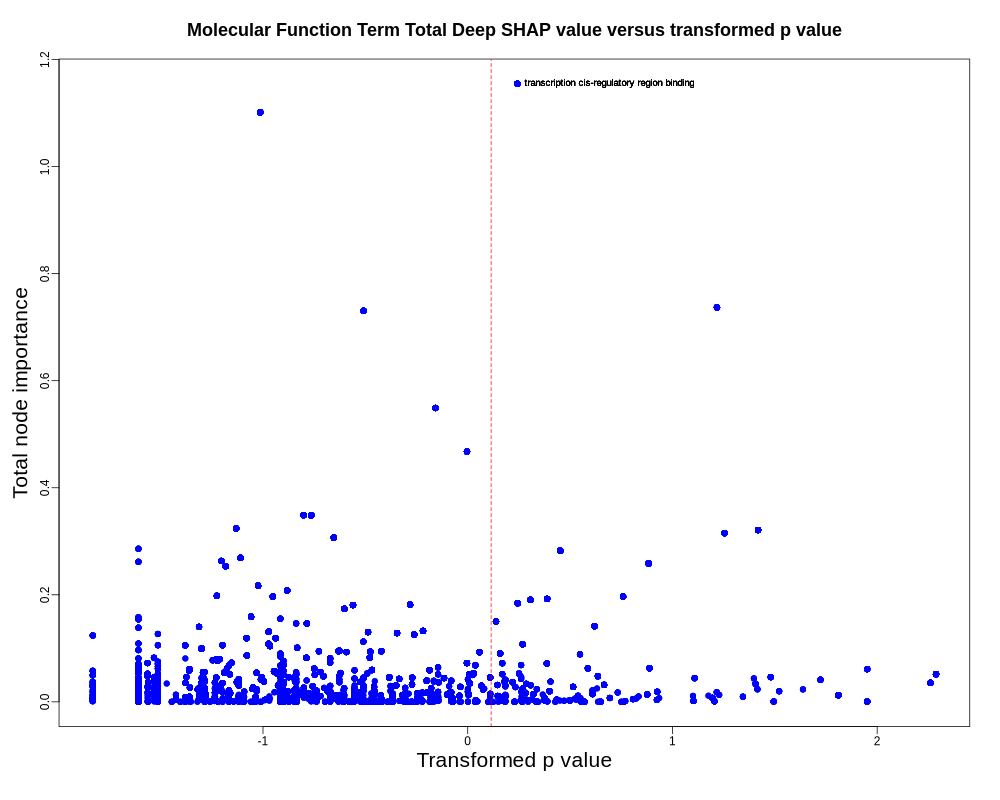

In [17]:
%%R -w 1000 -h 800
single_explanations <- read_csv("cancer_single_explanations.csv")
     
bind <- merge(results, single_explanations, by.x = "node_id", by.y = "target_node")

# We transform the differential p value by taking the log10 of the negative log10, to bring extreme values in, and have low p values appear higher

bind$differential_p_val_log10 <- log10(-log10(bind$differential_p_val))

# We create an alternate dataframe where we group by class_idx and node_id, so that we can extract class specific node importances

bind2 <- bind %>%
  group_by(node_id, class_idx) %>%
  summarize(
    total_importance = sum(normalized_importance, na.rm = TRUE),
    across(everything())
  ) %>%
  ungroup()

# To sum up all nodes for a GO term, we create bind_combined_node

bind_combined_node <- bind %>%
  group_by(node_id) %>%
  summarize(
    total_importance = sum(normalized_importance, na.rm = TRUE),
    across(everything())
  ) %>%
  ungroup()

# we filter out just the molecular function, our opinion is that it is a higher quality ontology

bind_combined_node <- bind_combined_node %>% filter(ontology == "molecular_function")

bind_combined_node$differential_p_val_log10 <- log(-log10(bind_combined_node$differential_p_val))

par(mgp = c(2, 0.5, 0))  
plot(bind_combined_node$differential_p_val_log10, bind_combined_node$total_importance,
     xlab = "Transformed p value",
     ylab = "Total node importance",
     main = "Molecular Function Term Total Deep SHAP value versus transformed p value",
     cex.lab = 1.75,
     cex.main = 1.5,
     pch = 19,
     col = "blue")

# we create a vertical line at log10(-log10(0.05)) to show where the hypergeometric significance is set at in our transformed p value

abline(v = log10(-log10(0.05)), col = "red", lty = 2)

# we extract indices of top 5 points by total_importance
top5_indices <- order(bind_combined_node$total_importance, decreasing = TRUE)[1:5]

# plot labels for the top 5 points
text(x = bind_combined_node$differential_p_val_log10[top5_indices],
     y = bind_combined_node$total_importance[top5_indices],
     labels = bind_combined_node$node_name[top5_indices],
     pos = 4, 
     offset = 0.5,
     cex = 0.8)




The correlation between importances and hypergeometric p values is very low and it appears there is orthogonality in what GO terms they stress. But, this is not necessarily disheartening. The hope with future work is that BINN analysis can extract information differentially from the geometric, and at this point we are not concerned about false negatives.

In this plot, the x axis is a transformed p value, where any value greater than 0.5 is considered statistically significant in the hypergeometric test. The highest scoring rows for the geometric differential test are: 


In [22]:
bind_combined_node = robjects.globalenv['bind_combined_node']

bind_combined_node_pd = pandas2ri.rpy2py(bind_combined_node)

print("\nHead of dataframe sorted by differential_p_val_log10:")
sorted_by_pval = bind_combined_node_pd.sort_values(by='differential_p_val_log10', ascending=False)
display(sorted_by_pval.head())


Head of dataframe sorted by differential_p_val_log10:


,node_id,class_idx,total_importance,ontology,node_name,raw_p_underrep,raw_p_overrep,FWER_underrep,FWER_overrep,differential_p_val,source_layer,target_layer,source_node,importance,normalized_importance,differential_p_val_log10
15733,GO:0004984,0.0,0.017034,molecular_function,olfactory receptor activity,1.411447e-10,1.0,0.0,1.0,1.411447e-10,0.0,1.0,ENSG00000179468,0.000069,0.000027,0.993451
15734,GO:0004984,0.0,0.017034,molecular_function,olfactory receptor activity,1.411447e-10,1.0,0.0,1.0,1.411447e-10,0.0,1.0,ENSG00000221910,0.000000,0.000000,0.993451
15735,GO:0004984,0.0,0.017034,molecular_function,olfactory receptor activity,1.411447e-10,1.0,0.0,1.0,1.411447e-10,0.0,1.0,ENSG00000127780,0.000000,0.000000,0.993451
15736,GO:0004984,0.0,0.017034,molecular_function,olfactory receptor activity,1.411447e-10,1.0,0.0,1.0,1.411447e-10,0.0,1.0,ENSG00000172150,0.000000,0.000000,0.993451
15737,GO:0004984,0.0,0.017034,molecular_function,olfactory receptor activity,1.411447e-10,1.0,0.0,1.0,1.411447e-10,0.0,1.0,ENSG00000169484,0.000000,0.000000,0.993451


Comparatively, the highest importances reported by the BINN, which are:

In [23]:
print("\nHead of dataframe sorted by total_importance:")
sorted_by_importance = bind_combined_node_pd.sort_values(by='total_importance', ascending=False)
display(sorted_by_importance.head())


Head of dataframe sorted by total_importance:


,node_id,class_idx,total_importance,ontology,node_name,raw_p_underrep,raw_p_overrep,FWER_underrep,FWER_overrep,differential_p_val,source_layer,target_layer,source_node,importance,normalized_importance,differential_p_val_log10
2466,GO:0000976,1.0,0.606601,molecular_function,transcription cis-regulatory region binding,0.952796,0.053222,1.0,1.0,0.053222,0.0,1.0,ENSG00000172888,0.000003,1.186535e-06,0.105139
2465,GO:0000976,1.0,0.606601,molecular_function,transcription cis-regulatory region binding,0.952796,0.053222,1.0,1.0,0.053222,0.0,1.0,ENSG00000188785,0.000001,4.665888e-07,0.105139
2480,GO:0000976,1.0,0.606601,molecular_function,transcription cis-regulatory region binding,0.952796,0.053222,1.0,1.0,0.053222,0.0,1.0,ENSG00000149948,0.001823,4.217591e-04,0.105139
2479,GO:0000976,1.0,0.606601,molecular_function,transcription cis-regulatory region binding,0.952796,0.053222,1.0,1.0,0.053222,0.0,1.0,ENSG00000143006,0.000000,0.000000e+00,0.105139
2478,GO:0000976,1.0,0.606601,molecular_function,transcription cis-regulatory region binding,0.952796,0.053222,1.0,1.0,0.053222,0.0,1.0,ENSG00000167548,0.003909,9.564449e-04,0.105139


### Classification importance per treatment

To continue the discussion, we note that each node has 2 importance values, denoted by different values of node_idx, corresponding to different treatment types.

To compare the importances of the node's for their classification of the two different cases, we are summing Deep SHAP value across node name as well as class_idx. We then plot the value of classification importance for case 0 versus case 1. 

This suggests that the importance metrics in this case are relatively invariant between treatment groups. Most of the variation appears to be in the low importance values, which are dominated by stochastic noise. It will be interesting to compare this further in more complex designs.

It’s anticipated this would be more interesting with more treatment levels, as it could appear that certain nodes drive classification of a treatment level of interest.

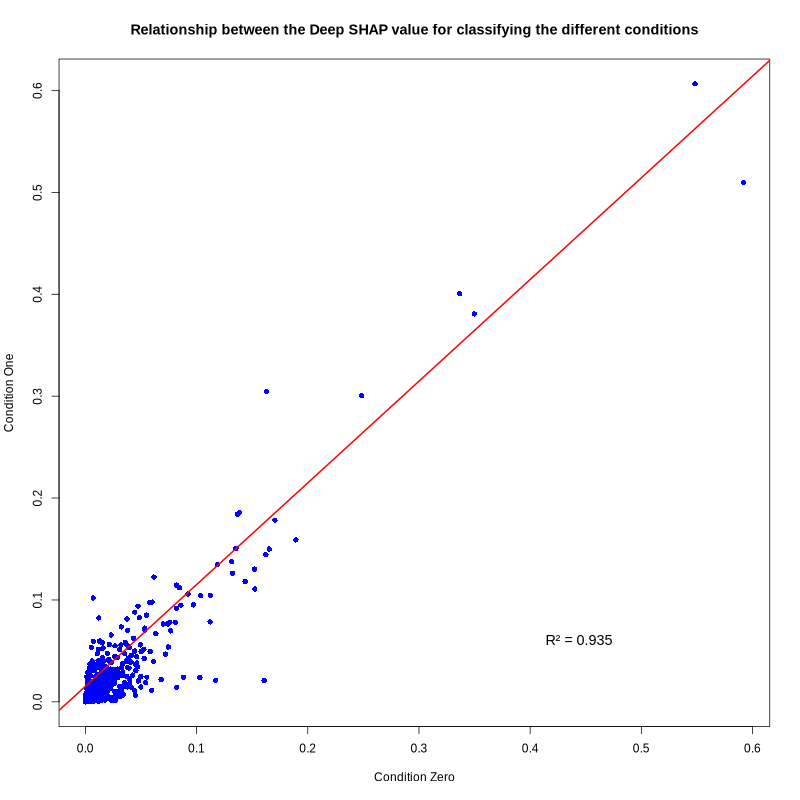

In [24]:
%%R -w 800 -h 800

# we extract the zeroth and first classification to see what importance a GO term has to classify that level of treatment

bind_combined_node <- bind2 %>% filter(ontology == "molecular_function")

zero_nodes <- bind_combined_node %>% filter(class_idx == 0)
zero_nodes$zero_importance <- zero_nodes$total_importance
one_nodes <- bind_combined_node %>% filter(class_idx == 1)
one_nodes$one_importance <- one_nodes$total_importance

merged <- merge(one_nodes, zero_nodes, by="node_id")

# Create linear model to extract R-squared value
model <- lm(merged$one_importance ~ merged$zero_importance)
r_squared <- summary(model)$r.squared

plot(merged$zero_importance, merged$one_importance,
     col = "blue", pch = 16,
     xlab = "Condition Zero",
     ylab = "Condition One",
     main = "Relationship between the Deep SHAP value for classifying the different conditions")

# Add regression line
abline(model, col = "red", lwd = 2)

# Add R-squared text
text_x <- min(merged$zero_importance) + 0.75 * (max(merged$zero_importance) - min(merged$zero_importance))
text_y <- min(merged$one_importance) + 0.1 * (max(merged$one_importance) - min(merged$one_importance))
text(text_x, text_y, labels = paste("R² =", round(r_squared, 3)), cex = 1.2)



To further explore this, we plotted the difference in their class importance compared with the transformed hypergeometric p value. 

NOTE: the apparent binning at the far end is due to the discrete nature of ontological terms with few associated genes. In these cases, all GO terms with, for example, three genes in the gene set, will get the same p value if only one gene is found in the differentially expressed list, whereas they will get disparate importances in the BINN.

`summarise()` has grouped output by 'node_id'. You can override using the
`.groups` argument.


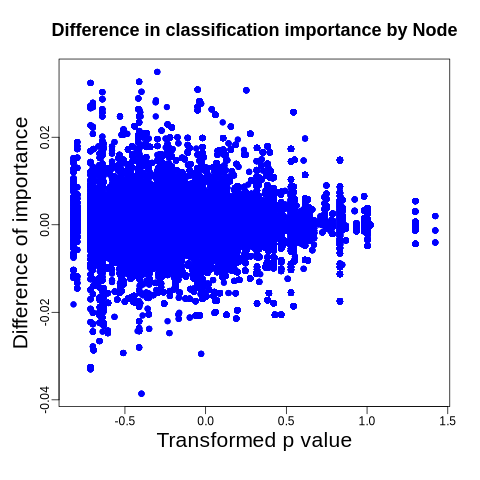

In [25]:
%%R

#we create a new dataframe for finding the difference between the two classification importances

result <- bind2 %>%
  group_by(node_id) %>%
  summarize(importance_diff = normalized_importance[class_idx == 1] - 
              normalized_importance[class_idx == 0]) %>%
  ungroup()



result_df <- bind2 %>%
  left_join(result, by = "node_id")

par(mgp = c(2, 0.5, 0))  
plot(result_df$differential_p_val_log10, result_df$importance_diff,
     xlab = "Transformed p value",
     ylab = "Difference of importance",
     main = "Difference in classification importance by Node",
     cex.lab = 1.75,
     cex.main = 1.5,
     pch = 19,
     col = "blue")


### Conclusions

While still preliminary data, BINNs still appear promising for application in ontological analysis, especially when considering we can use multiple condition levels while the hypergeometric offers only binary classification. Thusly, BINNs may be helpful in more complex study designs. This small analysis is not intended to be a final statement on their applicability, this was a brief exploration of quantifying their relation to traditional methods. Additionally, a major limitation is our lack of broad hyperparameter testing, which will need to be explored further.